# USGS MOC Software

The USGS MOC software is a specialized modeling tool developed to simulate groundwater flow, solute transport, and some chemical reactions within aquifers. It is based on numerical modeling principles and has evolved over the years to address complex hydrogeological scenarios. The software employs a modular framework, allowing users (with programming expertise) to tailor it to specific applications, making it an invaluable asset for groundwater professionals and researchers.


:::{note}
I choose MOC instead of MODFLOW/MODPATH because the program is easier to understand and get working.  Accessing MODFLOW using FloPy or ModelMUSE is far more challenging than the pretty pictures on the web-a-rama suggest. You can examine how to install MODFLOW at [MODFLOW on a JupyterHub](http://54.243.252.9/ce-4363-webroot/ce4363notes/lessons/groundwatermodels/installing.pdf) and how to access using [MODFLOW using Jupyter Example(s)](http://54.243.252.9/ce-4363-webroot/ce4363notes/_build/html/lessons/groundwatermodels/15gwmodels-examples.html)
:::


## Background

MOC is based on similar concepts to the [DPRW](https://www.osti.gov/biblio/7148095)  model but has some subtle differences, the primary difference is in MOC particles have the attribute of concentration rather than mass.

USGS-MOC is actually two models:
- Groundwater flow model
- Contaminant transport model

USGS-MOC solves two systems of equations:

1. $\nabla \cdot (T \nabla(h) ) = S\frac{\partial h}{\partial t} + W$
2.  $\nabla \cdot (bD\nabla(C) - bCV) -\frac{C`W}{n} - \lambda C = Rb \frac{\partial C}{\partial t}$

where
- $W = Q - \frac{K_z}{m}(H_s-h)$; (a pumping and leakage term)
- $C'$ = concentration in source or sink fluid

:::{note}
The documentation states that it only models non-reactive transport but modifications since 1980 allow for first order decay and reversible linear instantaneous adsorbtion.:::

The version used in the class models:
- Advective transport
- Dispersive transport
- Fluid sources/sinks
- Simple decay and fluid/solid reaction terms

Assuming that gradients of fluid density, viscosity, and temperature do not affect the velocity distribution.  There is a version called MOCDense that does consider density as part of the transport process.

MOC can be used as a building block for a multi-component reactive system (with some effort!).  This approach was used to create BIOPLUME-II/III programs (pp 269-273).

**Groundwater Flow Conceptualizations**:

$$\frac{\partial }{\partial x} (T_{xx} \frac{\partial h}{\partial x}) + \frac{\partial }{\partial x} (T_{yy} \frac{\partial h}{\partial y}) =  S\frac{\partial h}{\partial t}  + Q(x,y,t) - \frac{K_z(x,y)}{m}(H_s(x,y,t)-h(x,y,t))$$

![](celldiagram.png)

Velocity Field in Aquifer:

$$V_x = -\frac{K_{xx}}{n} \frac{\partial h}{\partial x} $$

$$V_y = -\frac{K_{yy}}{n} \frac{\partial h}{\partial y} $$


where        $K_{ii}  = \frac{T_{ii}}{b}$ 

Assumptions implicit in MOC include:

- Darcy's law is valid.
- Hydraulic head is the significant driving mechanism.
- Porosity is uniform in space and constant in time.
- Hydraulic conductivity is constant in time.
- Gradients of fluid density, viscosity, and temperature do not affect the fluid velocity (MOC-Dense relaxes these requirements).
- No chemical reactions (except decay and LEA).
- Ionic and molecular diffusion are negligible compared to hydrodynamic dispersion.
- Vertical variations in head and concentration are negligible.
- Aquifer is homogeneous and isotropic with respect to the dispersivity field.

**Numerical Methods:**

*Flow* equation assumes coordinate axes are aligned with principal directions of hydraulic anisotropy. An implicit finite difference solution by ADI method is used to compute `head(x,y,t)`

Numerical differentiation by centered finite difference to compute `grad(head(x,y,t)$`

*Transport* solves the diffusion equation along a characteristic line. Particle tracking is used to determine the characteristic trajectory; produces a system of ODE's along the characteristics.

Reuse of the ADI method on a finite differences is used to solve system of parabolic ODE's for concentration centered at computation particle. Superposition is then applied to recover concentration (for all particles tracked). The result is  `C(x,y,t)`

USGS-MOC (Method of Characteristics) Model

- Particles have concentrations instead of mass (different from DPRW)
- Average concentration of a cell is:$C_j = \sum_{i=1}^{NP} \frac{C_i^j}{NP}$ where $C_i$  is the concentration of the $i$-th particle located in cell $j$.
- A particle moves under advective forces the same way as in DPRW (ie.  $x_{pk}  =x_{pk-1}   + \Delta t V_x [x_{pk} ; t]$)
- Velocities  (local) are computed using bi-linear interpolation.

Bi-Linear Interpolation (MOC)

$V_x^p  = \frac{V_x(i,j) + V_x(i,j+1) + V_x(i+1/2,j) + V_x(i+1/2,j+1)}{4}$

$V_y^p  = \frac{V_y(i,j) + V_y(i+1,j) + V_y(i,j+1/2) + V_y(i+1,j+1/2)}{4}$

see pg. 5 of documentation for more detail.

![](particleV.png)

After advective move of particles dispersive spreading is computed from

$$\frac{DC}{Dt} = \frac{1}{b}  [ \frac{\partial}{\partial x_i}( bD_{ij} \frac{\partial C}{\partial x_{j}} )  ]~~\text{for} i=1,2; j=1,2$$

where $\frac{DC}{Dt}$ is the [material (or total derivative)](https://en.wikipedia.org/wiki/Material_derivative). 

This equation has same structure as flow equation and is calculated using similar methods. 

:::{note} 
Equation 39 in the documentation is explicitly solved during the particle movement phase. 
:::

Lastly, concentrations are adjusted for decay in a manner analogous to DPRW (or simply using 1st-order decay). Read pp 11-12 about stability.

Boundary conditions: constant flux and constant head.

:::{note}  
The model requires a no-flow boundary around the modeled area and this requirement must be explicitly included when constructing the input file. 
:::

Read pp 14-19 carefully.

## Setting up a model

As users we have to translate the conceptual model into input files for the code to solve.

![](modelingworkflow.png)

*USGS MOC Data Files*

The data file contains records (cards, rows) that have fields (groups of columns) that tell MOC what to simulate.

Consider "input file" below:

![](inputfile.png)

The first record for MOC is a title record that can contain anything you want - usually it is filled with some useful title:
"EXAMPLE PROBLEM #3 -- TEST PROBLEM FOR ...."
Remaining records describe the conceptual model to the computer.

The figure below examines some of the input file structure

![](inputfile2.png)

**Record 2** contains 18 items as follows:

1.	`NTIM` -- time steps/stress period
2.	`NPMP` -- # stress periods
3.	`NX` -- x direction mesh size
4.	`NY` -- y direction mesh size
5.	`NPMAX` -- maximum particles in system (use 3200)
6.	`NPNT` -- time steps for printing
7.	`NITP` -- Use 7
8.	`NUMOBS` -- number of observations (5 max unless you recompile code)
9.	`ITMAX` -- Iterations for ADI (Use 100 for first guess)
10.	`NREC` -- # pumping/recharge wells
11.	`NPTPND` -- # particles per node (Use 9 unless too slow, use 4)
12.	`NCODES` -- up to 10, used to define IC's & BC's
13.	`NPNTMV` -- usually use 0, example uses 10.
14.	`NPNTVL` -- usually use 1 or 2.
15.	`NPNTD` -- see documentation.
16.	`NPDELC` -- see documentation.
17.	`NPNCHV` -- use 0 (unless you have compiler, and know what punching to a "unit" means)
18.	`NREACT` -- 0 non-reactive system; 1 otherwise.

**Record 3** contains 12 items as follows:

1.	`PINT` -- pump period (years)
2.	`TOL` -- stopping criterion - keep fairly small 0.0001
3.	`POROS` -- Porosity
4.	`BETA` -- Longitudinal dispersivity in feet
5.	`S` -- storage coefficient
6.	`TIMX` -- time step multiplier
7.	`TINIT` -- Initial time step
8.	`XDEL` -- delta x
9.	`YDEL` -- delta y
10.	`DLTRAT` - transverse dispersivity/longitudinal 	dispersivity
11.	`CELDIS` -- see documentation
12.	`ANFCTR` -- ratio of transmissivity in y direction to transmissivity in x direction ($\frac{T_x}{T_y}$).

**Record(s) 4 - NREC** 

Various items, like head arrays, transmissivity arrays and similar data structures.

See documentation.



<hr>

## Example 1

Alluvial valley with lakes as shown. Mountains are hydrogeologic barriers. Region is arid.

Problem: Fuel spill at parking area near lake introduces contamination at 100 mg/l over area shown; How will plume spread over time?

![](example1-area.png)


### Conceptual model:

- Assume 2D confined flow approximation is valid (small drawdowns compared to saturated thickness)
- No pumping
- Recharge = Evaporation (so net rainfall to aquifer is negligible)
- Mountains are no-flow boundaries.

Translate into a computational grid:

![](concept2grid.png)

Using the sketch above we can construct an input file for USGS-MOC to study the question.

Input Data - The conceptual model can be entered as
(1) No dispersion
(2) Dispersion

#### Case (1)

![](moco1-1.png)

![](moco1-2.png)

Heres what the file looks like:

```
Example 1 From Notes -- Zero Dispersion Simulation 
1,1,9,9,3200,1,7,1,100,0,9,2,10,1,0,0,0,0   
2.0,0.001,0.30,0.0,0.0,0.0,0.0,900.0,900.0,0.30,0.49,1.0
5,5                        Observation Well
0  0.1                     Transmissivity
0  20.0                    Thickness
0  0.0                     Recharge
1  1.0                     Boundary and I/C array
0 0 0 0 0 0 0 0 0              
0 0 0 0 0 1 1 1 0 
0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 
0 2 2 2 0 0 0 0 0
0 0 0 0 0 0 0 0 0 
1,1.00,0.00,0.00,0        Leakance terms at special nodes
2,1.00,0.00,0.00,0
1  100.0       initial head
0  0  0  0  0  0  0  0  0
0  0  0  0  0  1  1  1  0
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0 
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0
0 .8 .8 .8  0  0  0  0  0
0  0  0  0  0  0  0  0  0
1  100.0       initial concentration
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0
0  0  0  0  1  1  1  1  0
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0 
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0

2.65,0.0,0.0                     rho-s,Kd,lambda
```

Here is the file for using with the Windows application [MOC01.INP (Windows)](http://54.243.252.9/ce-5364-webroot/ce5364notes/chapters/12usgsmocmodel/winmoc/example1/MOC01.INP)

The script below runs it on the ARM-based webserver (slightly different syntax, but uses same input file)

In [19]:
! cp ./armmoc/bin/usgsmoc.exe ./
! cp ./armmoc/example01/MOC01.INP ./
! cp ./armmoc/example01/moc01.sup ./
! ./usgsmoc.exe < moc01.sup ;
# next line lists output file on server - probably want to use an editor to parse the file for map making
! cat MOC01-NO-D.OUT ;

1U.S.G.S. METHOD-OF-CHARACTERISTICS MODEL FOR SOLUTE TRANSPORT IN GROUND WATER
0Example 1 From Notes -- Zero Dispersion Simulation                              
 
0                     I N P U T     D A T A
0                       GRID DESCRIPTORS

             NX    (NUMBER OF COLUMNS)  =     9
             NY    (NUMBER OF ROWS)     =     9
             XDEL  (X-DISTANCE IN FEET) =   900.0
             YDEL  (Y-DISTANCE IN FEET) =   900.0
0                       TIME  PARAMETERS

             NTIM   (MAX. NO. OF TIME STEPS)       =      1
             NPMP   (NO. OF PUMPING PERIODS)       =      1
             PINT   (PUMPING PERIOD IN YEARS)      =      2.000
             TIMX   (TIME INCREMENT MULTIPLIER)    =      0.00
             TINIT  (INITIAL TIME STEP IN SEC.)    =      0.
0              HYDROLOGIC AND CHEMICAL PARAMETERS

             S       (STORAGE COEFFICIENT)       =      0.000000
             POROS   (EFFECTIVE POROSITY)        =      0.300
             BETA    (LONGI

We can use this data file for case 2 by changing the longitudinal dispersivity term from 0 to 90 (or whatever mixing length is appropriate).

#### Case (2)

Modify above

```
Example 1 From Notes -- Non-Zero Dispersion Simulation 
1,1,9,9,3200,1,7,1,100,0,9,2,10,1,0,0,0,0   
2.0,0.001,0.30,90.0,0.0,0.0,0.0,900.0,900.0,0.30,0.49,1.0
5,5                        Observation Well
0  0.1                     Transmissivity
0  20.0                    Thickness
0  0.0                     Recharge
1  1.0                     Boundary and I/C array
0 0 0 0 0 0 0 0 0              
0 0 0 0 0 1 1 1 0 
0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 
0 2 2 2 0 0 0 0 0
0 0 0 0 0 0 0 0 0 
1,1.00,0.00,0.00,0        Leakance terms at special nodes
2,1.00,0.00,0.00,0
1  100.0       initial head
0  0  0  0  0  0  0  0  0
0  0  0  0  0  1  1  1  0
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0 
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0
0 .8 .8 .8  0  0  0  0  0
0  0  0  0  0  0  0  0  0
1  100.0       initial concentration
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0
0  0  0  0  1  1  1  1  0
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0 
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0

2.65,0.0,0.0                     rho-s,Kd,lambda
```

Below is the output with dispersion active

In [20]:
! cat MOC01-YES-D.OUT ;

1U.S.G.S. METHOD-OF-CHARACTERISTICS MODEL FOR SOLUTE TRANSPORT IN GROUND WATER
0Example 1 From Notes -- Non-Zero Dispersion Simulation                          
 
0                     I N P U T     D A T A
0                       GRID DESCRIPTORS

             NX    (NUMBER OF COLUMNS)  =     9
             NY    (NUMBER OF ROWS)     =     9
             XDEL  (X-DISTANCE IN FEET) =   900.0
             YDEL  (Y-DISTANCE IN FEET) =   900.0
0                       TIME  PARAMETERS

             NTIM   (MAX. NO. OF TIME STEPS)       =      1
             NPMP   (NO. OF PUMPING PERIODS)       =      1
             PINT   (PUMPING PERIOD IN YEARS)      =      2.000
             TIMX   (TIME INCREMENT MULTIPLIER)    =      0.00
             TINIT  (INITIAL TIME STEP IN SEC.)    =      0.
0              HYDROLOGIC AND CHEMICAL PARAMETERS

             S       (STORAGE COEFFICIENT)       =      0.000000
             POROS   (EFFECTIVE POROSITY)        =      0.300
             BETA    (LONGI

Now will try to make a contour plotting tool to operate on cut-and-paste arrays

In [29]:
ascii_array = [
[    0 ,   0 ,   0 ,   0 ,  0   , 0   , 0   , 0   , 0],
[    0 ,   0 ,   2 ,   0 ,   0  ,  0  ,  0  ,  0  ,  0],
[    0 ,   0 ,   3 ,   1 ,   0  ,  0  ,  0  ,  1  ,  0],
[    0 ,   0 ,   3 ,   5 ,   3  ,  2   , 2  ,  2  ,  0],
[    0 ,   1 ,  37 ,  20 ,   9  ,  8  ,  8  ,  8  ,  0],
[    0 ,   1 ,  21 ,  55 ,  46  , 28  , 54  , 43  ,  0],
[    0 ,   0 ,   5 ,  10 ,   7  ,  6  ,  4  ,  4  ,  0],
[    0 ,   0 ,   1 ,   3 ,   1  ,  0  ,  0  ,  0  ,  0],
[    0 ,   0 ,   0 ,   0 ,   0  ,  0  ,  0  ,  0  ,  0],
]

distancex=[1,2,3,4,5,6,7,8,9]
distancey=[1,2,3,4,5,6,7,8,9]

type(distancex)

list

Text(0.5, 1.0, 'Contour Plot of Concentration')

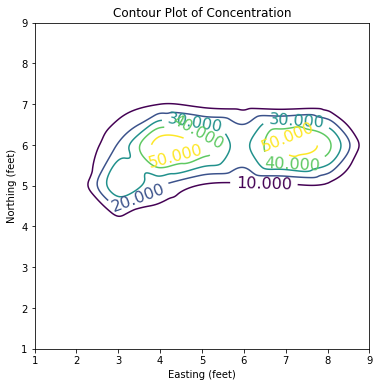

In [31]:
############# Contour Plot
nrows=9
ncols=9
my_xyz = [] # empty list
for irow in range(nrows):
    for jcol in range(ncols):
#        my_xyz.append([distancex[0][jcol],distancey[0][irow],head[irow][jcol]])
        my_xyz.append([distancex[jcol],distancey[irow],ascii_array[irow][jcol]])
import pandas
my_xyz = pandas.DataFrame(my_xyz) # convert into a data frame
#print(my_xyz) # activate to examine the dataframe
import numpy 
import matplotlib.pyplot
from scipy.interpolate import griddata
# extract lists from the dataframe
coord_x = my_xyz[0].values.tolist() # column 0 of dataframe
coord_y = my_xyz[1].values.tolist() # column 1 of dataframe
coord_z = my_xyz[2].values.tolist() # column 2 of dataframe
coord_xy = numpy.column_stack((coord_x, coord_y))
# Set plotting range in original data units
lon = numpy.linspace(min(coord_x), max(coord_x), 3000)
lat = numpy.linspace(min(coord_y), max(coord_y), 800)
X, Y = numpy.meshgrid(lon, lat)
# Grid the data; use linear interpolation (choices are nearest, linear, cubic)
Z = griddata(numpy.array(coord_xy), numpy.array(coord_z), (X, Y), method='cubic')
# Build the map
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(6, 6)
levels1 = [10,20,30,40,50]
CS = ax.contour(X, Y, Z, levels1)
ax.clabel(CS, inline=2, fontsize=16)
ax.set_xlabel('Easting (feet)')
ax.set_ylabel('Northing (feet)')
ax.set_title('Contour Plot of Concentration')

The computer software can also be used to model vertical aquifer slices and one-dimensional transport pg. 35 of the software documentation contains information on how to do these tasks.

<hr>

## Example 2 (Future Semester)

You wish to dispose of a liquid waste by injecting into an aquifer that is also used for water supply.

Wells W-1,W-2,W-3 are water supply wells.

The aquifer is 300 ft thick.


![](example2-area.png)

The hydraulic conductivity in each zone has been measured and is:

- Zone 1:   K = 0.472 cm/sec
- Zone 2:   K = 0.157 cm/sec
- Zone 3:   K = 0.047 cm/sec

Aquifer dispersivities are:
- $\alpha_l$  = 50 m  <br>
- $\alpha_t$  = 25 m

The aquifer porosity = 20%

The drinking water wells supply water at:

|Well|Pumping rate|
|---|---|
|W-1|30 cfs|
|W-2|_9 cfs|
|W-3|_9 cfs|

Your company, Waste Injection Safety Kompany, Inc. has an operating permit to inject at any of the three sites I-1,I-2, or I-3.
The permit states that the concentration for purple akenpucky must not exceed 250 mg/l at the water production wells.

Your company plans to inject (WISK away the purple akenpucky) the waste at 30 cfs at a concentration of 1000 mg/l at site I-3.

You want to determine:

1. Will you voliate your permit?
2. If not, can you inject more waste?
3. What is the general overall assimilative capacity of the aquifer system for purple ackenpucky if it is non-reactive?

Methods:

1. Construct a flow and transport model, determine steady state concentrations at w-1,w-2, and w-3.
2. Run the simulation with different waste loads, if you can do better than 30 cfs at 1000 mg/l you get a promotion.
3. Find the maximum mass that can be injected and meet the permit - this is the "regulatory assimilative capacity of the system"

Exercise:

Your regulatory agency is trying to use economic incentives to manage the aquifer system for both a water resource and a waste disposal resource.

The permit currently reads:

>"You may inject purple akenpucky at wells I-1,I-2, or I-3 and the concentration may not exceed 250 mg/l at the supply wells, W-1, W-2, and W-3. Non-compliance will result in fines of:
- \$25,000/day when blended drinking water from all three wells is less than 250 mg/l; 
- \$250,000/day when blended drinking water from all three wells is less than 1000 mg/l (but bigger than 250 mg/l); and 
- \$1,000,000/day otherwise."

The profit on ackenpucky disposal by injection is $130/mg disposed. 
- Is the penalty structure adequate from a microeconomic point of view to prevent permit violation?
- What if the profit were doubled?  Halved? 

### Initial Solution File

```
Example 3 - Waste Injection Example File
1,1,10,14,3200,1,7,3,200,4,4,2,0,0,0,0,0,1   
0.25 .0001 0.20 150.  0.0  0.0  0.0 150. 150.  0.5 1.0  1.0
0.005 2.65 15724800.0
 5 11
 7 11
 8 11
 4 4    -30.00   239.0
 5 11    30.00   0.00
 7 11    9.00    0.00
 8 11    9.00    0.00
1  1.416
0 0 0 0 0 0 0 0 0 0
0 10 10 10 10 10 10 10 10 0
0 10 10 10 10 10 10 10 10 0
0 10 10 10 10 10 10 10 10 0
0 10 10 10 10 10 10 10 10 0
0 3.34 3.34 3.34 3.34 3.34 3.34 3.34 3.34 0
0 3.34 3.34 3.34 3.34 3.34 3.34 3.34 3.34 0
0 3.34 3.34 3.34 3.34 3.34 3.34 3.34 3.34 0
0 3.34 3.34 3.34 3.34 3.34 3.34 3.34 3.34 0
0 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 0 0
0  300.0
1  1.0
0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
1  1.0
0 0 0 0 0 0 0 0 0 0 
0 1 1 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 2 2 2 2 2 2 2 2 0
0 0 0 0 0 0 0 0 0 0
  1      100.00    0.00      0.00 0
  2      200.00    0.00      0.00 0
1    300.00
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 1.8 1.79 1.78 1.77 1.76 1.75 1.74 1.73 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0  0.0
```

In [22]:
! cp ./armmoc/bin/usgsmoc.exe ./
! cp ./armmoc/example08/MOC08.INP ./
! cp ./armmoc/example08/moc08.sup ./
! ./usgsmoc.exe < moc08.sup ;
# next line lists output file on server - probably want to use an editor to parse the file for map making
! cat MOC08-TRY1.OUT ;

1U.S.G.S. METHOD-OF-CHARACTERISTICS MODEL FOR SOLUTE TRANSPORT IN GROUND WATER
0Example 3 - Waste Injection Example File                                        
 
0                     I N P U T     D A T A
0                       GRID DESCRIPTORS

             NX    (NUMBER OF COLUMNS)  =    10
             NY    (NUMBER OF ROWS)     =    14
             XDEL  (X-DISTANCE IN FEET) =   150.0
             YDEL  (Y-DISTANCE IN FEET) =   150.0
0                       TIME  PARAMETERS

             NTIM   (MAX. NO. OF TIME STEPS)       =      1
             NPMP   (NO. OF PUMPING PERIODS)       =      1
             PINT   (PUMPING PERIOD IN YEARS)      =      0.250
             TIMX   (TIME INCREMENT MULTIPLIER)    =      0.00
             TINIT  (INITIAL TIME STEP IN SEC.)    =      0.
0              HYDROLOGIC AND CHEMICAL PARAMETERS

             S       (STORAGE COEFFICIENT)       =      0.000000
             POROS   (EFFECTIVE POROSITY)        =      0.200
             BETA    (LONGI

<hr>

## Example 3 (Future Semester)

The town of Tivoli is planning to expand its water supply by constructing a well in an aquifer consisting of sandy silt.
The well is designed to pump continuously at a rate of 30,000 cubic meters per day.
The well construction was opposed by the Guadelupe Delta Conservation Authority claiming that the well would significantly reduce the groundwater discharge into the conservation area, thereby upsetting the salinity balance of the region.  

The conservation area has a southern border that is in contact with the bay with an average salinity of 10,000 ppm. 
The town planners claim that a groundwater divide located near the valley center will prevent any adverse change in flow to the delta, and thus have little effect on the salinity throughout the delta area.

![](tivoli.png)

You are tasked with constructing a two-dimensional plan view model of the area between the river and the delta prior to pumping using the information supplied below.

![](tivoli2.png)

1. Use the model to determine pre-development steady-state head distribution in the system.  Ignore any concentration outputs.  Use computed steady-state head from supplied boundary conditions as initial head in subsequent calculations 
> Step 1: Simulate with given conditions, get steady state heads.<br>
> Step 2: Copy these heads into the initial head arrayposition in the inout file - repeat the simulation.<br>
> Step 3: Continue run-copy-run until produce near-zero drawdown; this last run is an equilibrum state.<br>
2. Use the model to determine the average long-term salinity levels in the aquifer (the reported data values should reasonably agree with these long-term calculated values).  Prepare a contour map of groundwater heads and a contour map of salinity.  Calculate the area of acceptable habitatbetween the valley-conservation area interface and the bay. The authority uses a groundwater salinity value of 100 ppm as the upper limit of acceptable salinity for useful habitat.  It is generally accepted that the groundwater and surface water in the conservation area are (more or less) in chemical equilibrium.
3. Use the model to determine the salinity in the pumped water assuming Mission Creek is fresh water and Guadelupe bay has a salinity of 10,000 ppm.  Prepare a contour map of groundwater heads and a contour map of salinity.  If the acceptable salinity is 10 ppm, is the water acceptable to use as drinking water?
4. Use the model to support or refute the claim of the conservation authority that the reduced groundwater inflow will significantly decrease available habitat.  Determine the maximum acceptable pumping rate that can be used if 50% habitat loss is acceptable.  Determine the maximum acceptable pumping rate that can be used if 25% habitat loss is acceptable.

Tasks:

1. Convert all units to feet and seconds as used in the version of USGS-MOC

2. Build in input file of necessary geometry

```
GUADLUPE DELTA MODEL 20ROWS 11COLUMNS STEADY STATE
10,2,11,20,3200,1,7,3,100,1,9,2,0,1,0,0,0,0   
1000,0.0001,0.50,1000.0,0.0,0.0,0.0,1332.0,2100.0,0.10,0.49,1.0
6  6                          
6  12                         
6  18
5  6  0.0E-03 0.0             Pumping Well (set to 8.5e-03)
1  0.0035                     Transmissivity ft^2/sec
0 0 0 0 0 0 0 0 0 0 0              
0 3 3 3 3 3 3 3 3 3 0
0 3 3 3 3 3 3 3 3 3 0
0 3 3 3 3 3 3 3 3 3 0
0 3 3 3 3 3 3 3 3 3 0
0 3 3 3 3 3 3 3 3 3 0
0 3 3 3 3 3 3 3 3 3 0
0 3 3 3 3 3 3 3 3 3 0
0 3 3 3 3 3 3 3 3 3 0
0 3 3 3 3 3 3 3 3 3 0
0 3 3 3 3 3 3 3 3 3 0
0 3 3 3 3 3 3 3 3 3 0
0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0
0 2 2 2 2 2 2 2 2 2 0
0 2 2 2 2 2 2 2 2 2 0
0 2 2 2 2 2 2 2 2 2 0
0 2 2 2 2 2 2 2 2 2 0
0 2 2 2 2 2 2 2 2 2 0
0 2 2 2 2 2 2 2 2 2 0
0 0 0 0 0 0 0 0 0 0 0
1  90.0                     Thickness (ft)
0 0 0 0 0 0 0 0 0 0 0              
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 0 0 0
1  -3.7E-8                     Recharge array (ft/sec)
0 0 0 0 0 0 0 0 0 0 0              
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 1 1 1 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 0 0 0
1  1.0                     Boundary and I/C array
0 0 0 0 0 0 0 0 0 0 0              
0 2 2 2 2 2 2 2 2 2 0
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 
0 1 1 1 1 1 1 1 1 1 0
0 0 0 0 0 0 0 0 0 0 0
1,1.00,10000.00,0.00,0        Leakance terms at special nodes
2,1.00,0.0000,0.00,0
1  1.0                    Initial Head (ft)
0   0   0   0   0   0   0   0   0   0   0
0   6   6   6   6   6   6   6   6   6   0
0   7   7   7   7   7   7   7   7   7   0
0   9   9   9   9   9   9   9   9   9   0
0  10  10  10  10  10  10  10  10  10   0
0  10  10  10  10  10  10  10  10  10   0
0  11  11  11  11  11  11  11  11  11   0
0  12  12  12  12  12  12  12  12  12   0
0  12  12  12  12  12  12  12  12  12   0
0  12  12  12  12  12  12  12  12  12   0
0  12  12  12  12  12  12  12  12  12   0
0  12  12  12  12  12  12  12  12  12   0
0  12  12  12  12  12  12  12  12  12   0
0  11  11  11  11  11  11  11  11  11   0
0  10  10  10  10  10  10  10  10  10   0
0   8   8   8   8   8   8   8   8   8   0
0   7   7   7   7   7   7   7   7   7   0
0   5   5   5   5   5   5   5   5   5   0
0   3   3   3   3   3   3   3   3   3   0
0   0   0   0   0   0   0   0   0   0   0
1  1.0                            initial concentration (pph)
0    0    0    0    0    0    0    0    0    0    0
0    0    0    0    0    0    0    0    0    0    0
0    0    0    0    0    0    0    0    0    0    0
0    0    0    0    0    0    0    0    0    0    0
0    0    0    0    0    0    0    0    0    0    0
0    0    0    0    0    0    0    0    0    0    0
0    0    0    0    0    0    0    0    0    0    0
0    0    0    0    0    0    0    0    0    0    0
0    0    0    0    0    0    0    0    0    0    0
0    1    1    1    1    1    1    1    1    1    0
0    5    5    5    5    5    5    5    5    5    0
0    7    7    7    7    7    7    7    7    7    0
0   10   10   10   10   10   10   10   10   10    0
0   13   13   13   13   13   13   13   13   13    0
0   20   20   20   20   20   20   20   20   20    0
0   39   39   39   39   39   39   39   39   39    0
0  127  127  127  127  127  127  127  127  127    0
0  520  520  520  520  520  520  520  520  520    0
0 1547 1547 1547 1547 1547 1547 1547 1547 1547    0
0    0    0    0    0    0    0    0    0    0    0
1
10,1,7,100,1,0,1,0,0,0   
1000,0,0
5  6  0.0E-03 0.0             Pumping Well (set to 8.5e-03)
```

The script below will run the model (on my ARM machine)

In [1]:
#! cp ./armmoc/bin/usgsmoc.exe ./
#! cp ./armmoc/example03/MOC03.INP ./
#! cp ./armmoc/example03/moc03.sup ./
! ./usgsmoc.exe < moc03.sup ;
# next line lists output file on server - probably want to use an editor to parse the file for map making
! cat MOC03-TRY1.OUT ;

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
1U.S.G.S. METHOD-OF-CHARACTERISTICS MODEL FOR SOLUTE TRANSPORT IN GROUND WATER
0GUADLUPE DELTA MODEL 20ROWS 11COLUMNS STEADY STATE                              
 
0                     I N P U T     D A T A
0                       GRID DESCRIPTORS

             NX    (NUMBER OF COLUMNS)  =    11
             NY    (NUMBER OF ROWS)     =    20
             XDEL  (X-DISTANCE IN FEET) =  1457.0
             YDEL  (Y-DISTANCE IN FEET) =  2296.0
0                       TIME  PARAMETERS

             NTIM   (MAX. NO. OF TIME STEPS)       =     10
             NPMP   (NO. OF PUMPING PERIODS)       =      2
             PINT   (PUMPING PERIOD IN YEARS)      =    100.000
             TIMX   (TIME INCREMENT MULTIPLIER)    =      0.00
             TINIT  (INITIAL TIME STEP IN SEC.)    =      0.
0              HYDROLOGIC AND CHEMICAL PARAMETERS

             S       (STORAGE COEFFICIENT)       =      0.000000
       

Text(0.5, 1.0, 'Contour Plot of Heads from Guadelupe Basin after 100 years pumping')

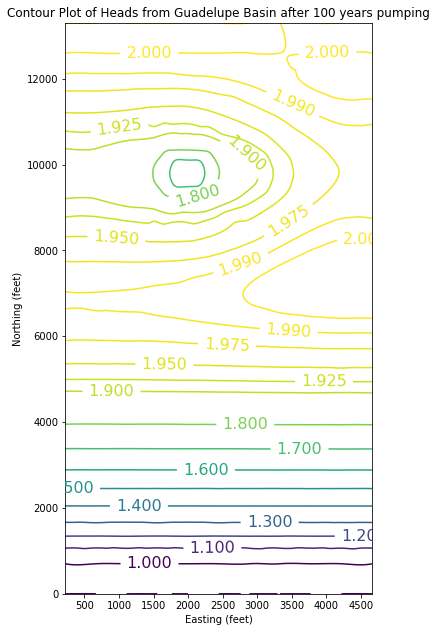

In [2]:
ascii_array=[
[2,2,2,2,2,2,2,2,2,2,2],
[2,2,2,2,2,2,2,2,2,2,2],
[1.9824704,1.9824704,1.9817755,1.9812523,1.9823327,1.9860897,1.9914353,1.9968044,2.0009695,2.0032144,2.0032144],
[1.9493786,1.9493786,1.9458412,1.9412092,1.9407227,1.9509342,1.9655228,1.9792917,1.9894292,1.9947191,1.9947191],
[1.9077647,1.9077647,1.8953256,1.8735055,1.8552067,1.8875707,1.9243329,1.9534483,1.9726357,1.9820581,1.9820581],
[1.8797366,1.8797366,1.8508128,1.7796579,1.6264312,1.7959227,1.8848174,1.9348898,1.9628007,1.9754839,1.9754839],
[1.9062448,1.9062448,1.8939348,1.8723718,1.8544265,1.8872218,1.9244401,1.953979,1.9734819,1.9830781,1.9830781],
[1.9459812,1.9459812,1.9427145,1.9386335,1.9389311,1.9501274,1.9657812,1.9805524,1.9914468,1.9971545,1.9971545],
[1.976452,1.976452,1.976164,1.9765218,1.9789592,1.9845336,1.9919303,1.9992708,2.0049506,2.0080323,2.0080323],
[1.9902456,1.9902456,1.9906493,1.9917361,1.9937963,1.9969799,2.0008261,2.0046107,2.0075548,2.009176,2.009176],
[1.9856354,1.9856354,1.9860716,1.9870122,1.9884389,1.9903391,1.9924731,1.9945204,1.9960834,1.9969483,1.9969483],
[1.9625396,1.9625396,1.9628748,1.9635591,1.9645021,1.9656767,1.9669334,1.9681117,1.9689833,1.9694683,1.9694683],
[1.9170766,1.9170766,1.9173128,1.9177851,1.918401,1.9191451,1.9199175,1.920631,1.9211405,1.9214248,1.9214248],
[1.8371684,1.8371684,1.8373234,1.8376294,1.8380111,1.8384659,1.8389282,1.8393522,1.8396425,1.8398047,1.8398047],
[1.7219858,1.7219858,1.7220795,1.7222678,1.7224904,1.7227548,1.7230192,1.7232617,1.7234179,1.7235076,1.7235076],
[1.5805758,1.5805758,1.5806312,1.5807443,1.5808709,1.5810217,1.5811706,1.5813077,1.58139,1.5814388,1.5814388],
[1.4130549,1.4130549,1.4130857,1.4131494,1.4132173,1.4132985,1.413378,1.4134515,1.4134926,1.4135177,1.4135177],
[1.2195073,1.2195073,1.219521,1.2195498,1.2195792,1.2196147,1.2196491,1.2196811,1.219698,1.2197086,1.2197086],
[1,1,1,1,1,1,1,1,1,1,1],
[1,1,1,1,1,1,1,1,1,1,1]
]

distancex=[0 for i in range(len(ascii_array[0]))]
distancey=[0 for j in range(len(ascii_array))]

deltax = 444
deltay = 700

distancex[0]=deltax/2

for i in range(1,len(distancex)):
    distancex[i]= distancex[i-1]+deltax


distancey[0]=deltay/2

for i in range(1,len(distancey)):
    distancey[i]= distancey[i-1]+deltay

dymax = max(distancey)

for i in range(len(distancey)):
    distancey[i]=dymax-distancey[i]


############# Contour Plot
nrows=len(distancey)
ncols=len(distancex)
my_xyz = [] # empty list
for irow in range(nrows):
    for jcol in range(ncols):
#        my_xyz.append([distancex[0][jcol],distancey[0][irow],head[irow][jcol]])
        my_xyz.append([distancex[jcol],distancey[irow],ascii_array[irow][jcol]])
import pandas
my_xyz = pandas.DataFrame(my_xyz) # convert into a data frame
#print(my_xyz) # activate to examine the dataframe
import numpy 
import matplotlib.pyplot
from scipy.interpolate import griddata
# extract lists from the dataframe
coord_x = my_xyz[0].values.tolist() # column 0 of dataframe
coord_y = my_xyz[1].values.tolist() # column 1 of dataframe
coord_z = my_xyz[2].values.tolist() # column 2 of dataframe
coord_xy = numpy.column_stack((coord_x, coord_y))
# Set plotting range in original data units
lon = numpy.linspace(min(coord_x), max(coord_x), 1100)
lat = numpy.linspace(min(coord_y), max(coord_y), 2100)
X, Y = numpy.meshgrid(lon, lat)
# Grid the data; use linear interpolation (choices are nearest, linear, cubic)
Z = griddata(numpy.array(coord_xy), numpy.array(coord_z), (X, Y), method='cubic')
# Build the map
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(5.5, 10.5)
levels1 = [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.925,1.95,1.975,1.99,2.0]
CS = ax.contour(X, Y, Z, levels1)
ax.clabel(CS, inline=2, fontsize=16)
ax.set_xlabel('Easting (feet)')
ax.set_ylabel('Northing (feet)')
ax.set_title('Contour Plot of Heads from Guadelupe Basin after 100 years pumping')

Text(0.5, 1.0, 'Contour Plot of Concentration from Guadelupe Basin')

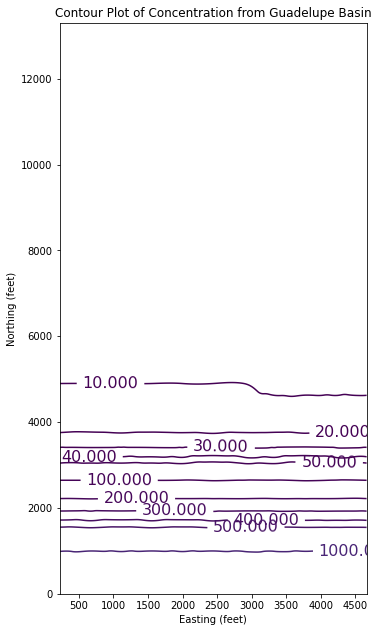

In [3]:
ascii_array=[
[0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0],
[1,1,1,1,1,1,1,1,1,1,1],
[5,5,5,5,5,5,5,5,5,5,5],
[7,7,7,7,7,7,7,7,7,7,7],
[10,10,10,10,10,10,10,9,9,9,9],
[13,13,13,13,13,13,13,13,13,13,13],
[27,27,27,27,27,27,27,27,27,27,27],
[76,76,76,76,76,76,76,76,76,76,76],
[237,237,237,237,237,237,237,237,237,237,237],
[612,612,612,612,612,612,612,612,612,612,612],
[1215,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215],
[1215,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215]
]

distancex=[0 for i in range(len(ascii_array[0]))]
distancey=[0 for j in range(len(ascii_array))]

deltax = 444
deltay = 700

distancex[0]=deltax/2

for i in range(1,len(distancex)):
    distancex[i]= distancex[i-1]+deltax


distancey[0]=deltay/2

for i in range(1,len(distancey)):
    distancey[i]= distancey[i-1]+deltay

dymax = max(distancey)

for i in range(len(distancey)):
    distancey[i]=dymax-distancey[i]


############# Contour Plot
nrows=len(distancey)
ncols=len(distancex)
my_xyz = [] # empty list
for irow in range(nrows):
    for jcol in range(ncols):
#        my_xyz.append([distancex[0][jcol],distancey[0][irow],head[irow][jcol]])
        my_xyz.append([distancex[jcol],distancey[irow],ascii_array[irow][jcol]])
import pandas
my_xyz = pandas.DataFrame(my_xyz) # convert into a data frame
#print(my_xyz) # activate to examine the dataframe
import numpy 
import matplotlib.pyplot
from scipy.interpolate import griddata
# extract lists from the dataframe
coord_x = my_xyz[0].values.tolist() # column 0 of dataframe
coord_y = my_xyz[1].values.tolist() # column 1 of dataframe
coord_z = my_xyz[2].values.tolist() # column 2 of dataframe
coord_xy = numpy.column_stack((coord_x, coord_y))
# Set plotting range in original data units
lon = numpy.linspace(min(coord_x), max(coord_x), 1100)
lat = numpy.linspace(min(coord_y), max(coord_y), 2100)
X, Y = numpy.meshgrid(lon, lat)
# Grid the data; use linear interpolation (choices are nearest, linear, cubic)
Z = griddata(numpy.array(coord_xy), numpy.array(coord_z), (X, Y), method='cubic')
# Build the map
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(5.5, 10.5)
levels1 = [10,20,30,40,50,100,200,300,400,500,1000,2000,3000,4000,5000,10000]
CS = ax.contour(X, Y, Z, levels1)
ax.clabel(CS, inline=2, fontsize=16)
ax.set_xlabel('Easting (feet)')
ax.set_ylabel('Northing (feet)')
ax.set_title('Contour Plot of Concentration from Guadelupe Basin')